In [31]:
import pandas as pd
import numpy as np

import yfinance
imported_data = yfinance.download(tickers = "^GSPC", period="1y")


[*********************100%%**********************]  1 of 1 completed


In [32]:
stock_data = imported_data[['Open', 'Close']]
stock_data = stock_data.reset_index()
stock_data

,Date,Open,Close
0,2023-10-05,4259.310059,4258.189941
1,2023-10-06,4234.790039,4308.500000
2,2023-10-09,4289.020020,4335.660156
3,2023-10-10,4339.750000,4358.240234
4,2023-10-11,4366.589844,4376.950195
...,...,...,...
247,2024-09-30,5726.520020,5762.479980
248,2024-10-01,5757.729980,5708.750000
249,2024-10-02,5698.140137,5709.540039
250,2024-10-03,5698.189941,5699.939941


In [33]:
ops = []
for i in range(1, len(stock_data['Open'] + 1)):
    result = ((stock_data['Open'][i] - stock_data['Close'][i-1]) / stock_data['Close'][i-1]) * 100
    #print(stock_data['Open'][i], " - ", stock_data['Close'][i-1], " / ", stock_data['Close'][i-1], " = ", result)
    ops.append(result)
#print(len(ops))
ops = pd.DataFrame({'OPS': ops})
#ops = ops.shift(1)
ops

stock_ops_data = pd.concat([stock_data['Date'], ops], axis=1)
stock_ops_data['OPS'] = stock_ops_data['OPS'].shift(1)
stock_ops_data



,Date,OPS
0,2023-10-05,NaN
1,2023-10-06,-0.549527
2,2023-10-09,-0.452129
3,2023-10-10,0.094330
4,2023-10-11,0.191582
...,...,...
247,2024-09-30,-0.203025
248,2024-10-01,-0.082430
249,2024-10-02,-0.185853
250,2024-10-03,-0.198792


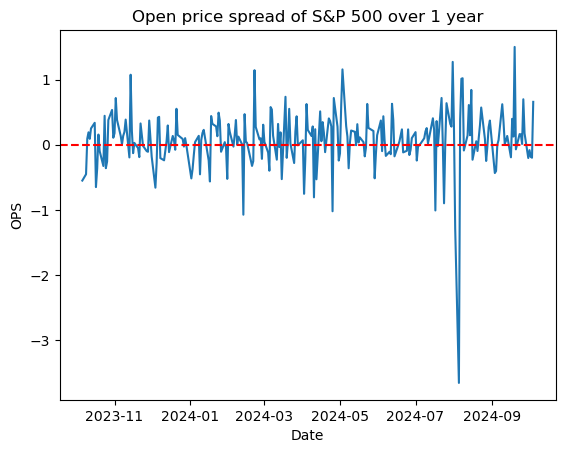

In [34]:
import matplotlib.pyplot as plt
graph_data = stock_ops_data.drop(0)
plt.plot(graph_data['Date'], graph_data['OPS'])
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Open price spread of S&P 500 over 1 year')
plt.xlabel('Date')
plt.ylabel('OPS')
plt.show()

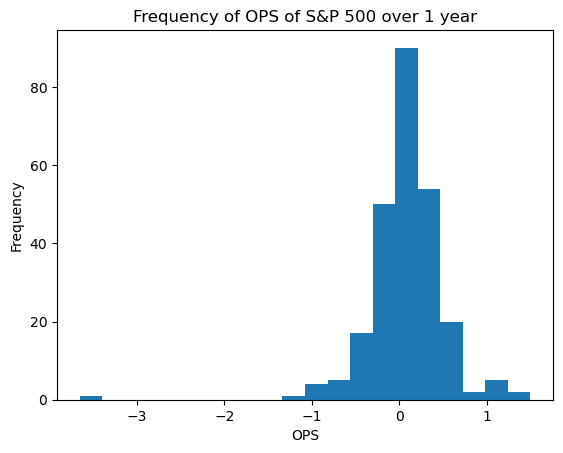

In [35]:
plt.hist(graph_data['OPS'], bins=20)
plt.title('Frequency of OPS of S&P 500 over 1 year')
plt.xlabel('OPS')
plt.ylabel('Frequency')
plt.show()

In [36]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [37]:
from statsmodels.tsa.stattools import adfuller
time_series = graph_data['OPS']
stationary_check = adfuller(time_series)
print('ADF Statistic: ', stationary_check[0])
print('p-value: ', stationary_check[1])
if(stationary_check[1] < 0.05):
    print('Data is stationary')
else:
    print('Data is not stationary')
    print('Differencing')
    time_series = time_series.diff().dropna()

ADF Statistic:  -12.61199949525695
p-value:  1.6475419963739253e-23
Data is stationary


c:\Users\olive\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


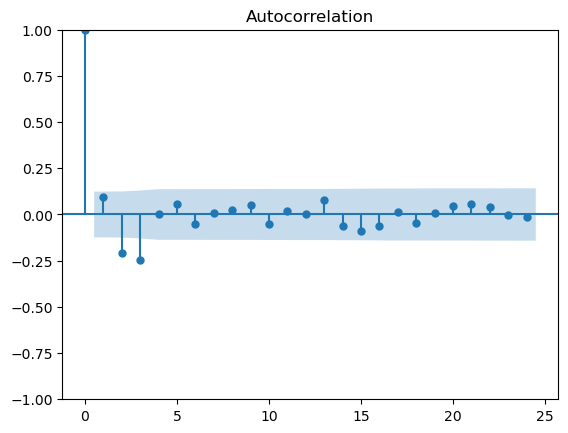

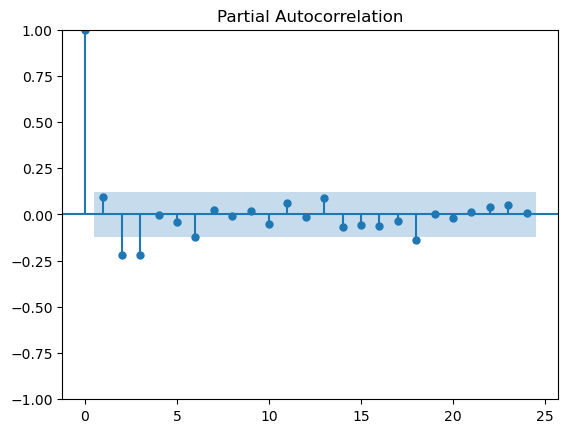

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(time_series)
plot_pacf(time_series)
plt.show()

In [39]:
model = ARIMA(time_series, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    OPS   No. Observations:                  251
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -150.803
Date:                Mon, 07 Oct 2024   AIC                            309.607
Time:                        13:01:03   BIC                            323.708
Sample:                             0   HQIC                           315.282
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0776      0.015      5.341      0.000       0.049       0.106
ar.L1          0.8113      0.121      6.723      0.000       0.575       1.048
ma.L1         -0.9204      0.090    -10.230      0.0

In [40]:
forecast = model_fit.forecast(steps=10)
print(forecast)

252   -0.021437
253   -0.002758
254    0.012397
255    0.024693
256    0.034669
257    0.042763
258    0.049330
259    0.054658
260    0.058981
261    0.062488
Name: predicted_mean, dtype: float64


In [41]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
test_data = time_series[-10:]
prediction = model_fit.forecast(steps=len(test_data))
mse = mean_squared_error(test_data, prediction)
mae = mean_absolute_error(test_data, prediction)
r2 = r2_score(test_data, prediction)
print('Mean Squared Error: ', mse)
print('Mean Absolute Error: ', mae)
print('R Squared Value: ', r2)


Mean Squared Error:  0.10911145223346277
Mean Absolute Error:  0.26320699588954943
R Squared Value:  -0.1100326648679184


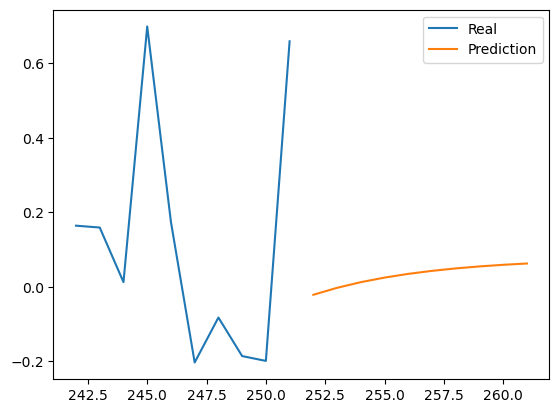

In [42]:
plt.plot(test_data, label='Real')
plt.plot(prediction, label='Prediction')
plt.legend()
plt.show()

In [56]:
from sklearn.preprocessing import MinMaxScaler
from keras.api.models import Sequential
from keras.api.layers import LSTM
from keras.api.layers import Dense

In [57]:
scaler = MinMaxScaler(feature_range=(0,1))
deep_learning_data = graph_data['OPS'].values.reshape(-1,1)
deep_learning_data = scaler.fit_transform(deep_learning_data)

In [58]:

time_intervals = 60
X, Y = [], []
for i in range(len(deep_learning_data) - time_intervals):
    X.append(deep_learning_data[i:i + time_intervals])
    Y.append(deep_learning_data[i + time_intervals])
X = np.array(X)
Y = np.array(Y)

In [59]:
training_set_size = int(len(X) * 0.8)
X_training, Y_training = X[:training_set_size], Y[:training_set_size]
X_testing, Y_testing = X[training_set_size:], Y[training_set_size:]

In [60]:
X_training = np.reshape(X_training, (X_training.shape[0], X_training.shape[1], 1))
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

In [61]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_training.shape[1], 1)))
LSTM_model.add(LSTM(units=50, return_sequences=False))
LSTM_model.add(Dense(units=1))
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\olive\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
LSTM_model.fit(X_training, Y_training, epochs=20, batch_size=32, validation_data=(X_testing, Y_testing))

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - loss: 0.2326 - val_loss: 0.0121
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0451 - val_loss: 0.0074
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0119 - val_loss: 0.0237
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0223 - val_loss: 0.0114
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0149 - val_loss: 0.0073
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0147 - val_loss: 0.0066
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0147 - val_loss: 0.0077
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0083 - val_loss: 0.0056
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0141 - val_loss: 0.0056
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0089 - val_loss: 0.0059
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0137 - val_loss: 0.0064


In [64]:
DL_prediction = LSTM_model.predict(X_testing)
DL_prediction = scaler.inverse_transform(DL_prediction)
Y_testing_scaled = scaler.inverse_transform(Y_testing.reshape(-1,1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step


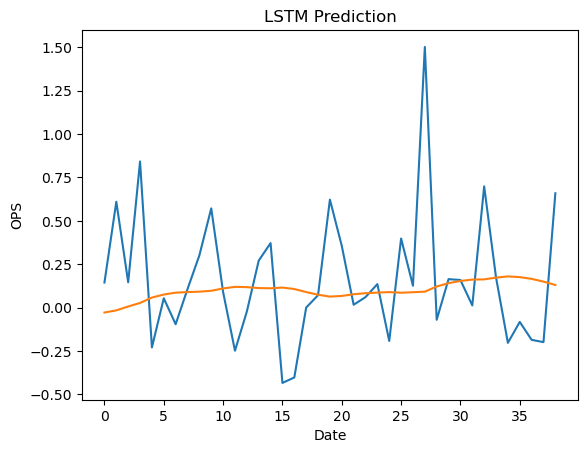

In [65]:
plt.plot(Y_testing_scaled, label='Actual')
plt.plot(DL_prediction, label='Prediction')
plt.title('LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('OPS')
plt.show()